# Прогнозирование оттока для фитнес-центра

В нашем распоряжении имеются данные о действующих клиентах фитнес-клуба: пол, возраст, проживание относительно локации клуба, срок абонемента, суммы затрат на дополнительные услуги центра, среднее количество посещений в неделю за весь период и за последний месяц, а также факт попадания клиента в отток в текущем месяце.

Заказчик планирует использовать аналитические данные для разработки стратегии взаимодействия с клиентами и снижения оттока.

Задачи исследования:
- сегментировать клиентов, описать характерные признаки каждой группы  
- выделить признаки, влияющие на склонность клиента к оттоку  
- спрогнозировать отток клиентов для следующего месяца  
- сформулировать рекомендации по улучшению стратегии удержания клиентов.

## Ознакомление с данными  и исследовательский анализ

Импортируем необходимые библиотеки

In [1]:
!pip install seaborn -Uq

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

Посмотрим на данные. Загрузим сначала часть датасета, посмотрим на типы, оптимизируем типы данных в случае необходимости, и выгрузим полный датасет с корректными типами данных

In [3]:
df_preview = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv', nrows=10)
df_preview
df_preview.dtypes

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Phone                                  int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                float64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
Churn                                  int64
dtype: object

В нашем датасете есть ряд столбцов с бинарными значениями (пол, наличие телефона и др, а также столбцы, в которых диапазон значений вряд ли выходит за границы [0-255] (возраст, срок абонемента, Lifetime) - для этих столбцов мы можем изменить тип данных на uint8, занимающий всего 1 байт памяти, для столбцов с типом данных float мы понизим разрядность до 32 бит.

In [4]:
# функция для изменения типа данных в зависимости от изначального типа - int или float
def downcast_data_type(col):
    float_cols = [
        'Avg_additional_charges_total',
        'Month_to_end_contract',
        'Avg_class_frequency_total',
        'Avg_class_frequency_current_month'
    ]
   
    if col in float_cols:
        df_preview[col] = pd.to_numeric(df_preview[col], downcast='float')
    else:
        df_preview[col] = pd.to_numeric(df_preview[col], downcast='unsigned')

for i in df_preview.columns:
    downcast_data_type(i)

df_preview.dtypes

gender                                 uint8
Near_Location                          uint8
Partner                                uint8
Promo_friends                          uint8
Phone                                  uint8
Contract_period                        uint8
Group_visits                           uint8
Age                                    uint8
Avg_additional_charges_total         float32
Month_to_end_contract                float32
Lifetime                               uint8
Avg_class_frequency_total            float32
Avg_class_frequency_current_month    float32
Churn                                  uint8
dtype: object

In [5]:
# создаем словарь с новыми типами данных и названиями колонок
dtypes = df_preview.dtypes
colnames = dtypes.index
types = [i.name for i in dtypes.values]
column_types = dict(zip(colnames, types))

# читаем файл целиком, передав нужные типы данных
df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv', dtype=column_types)

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   uint8  
 1   Near_Location                      4000 non-null   uint8  
 2   Partner                            4000 non-null   uint8  
 3   Promo_friends                      4000 non-null   uint8  
 4   Phone                              4000 non-null   uint8  
 5   Contract_period                    4000 non-null   uint8  
 6   Group_visits                       4000 non-null   uint8  
 7   Age                                4000 non-null   uint8  
 8   Avg_additional_charges_total       4000 non-null   float32
 9   Month_to_end_contract              4000 non-null   float32
 10  Lifetime                           4000 non-null   uint8  
 11  Avg_class_frequency_total          4000 non-null   float

In [7]:
df.duplicated().sum()

0

Датасет включает в себя 4000 записей. Пропуски и дубликаты отсутствуют. Все 14 столбцов содержат данные типа int или float, категориальные значения отсутствуют. Объем занимаемой памяти не превышает после преобразований составил чуть более 100 КВ.

Структура датасета:

Текущие поля в датасете:  
Данные клиента за предыдущий до проверки факта оттока месяц:  
- `gender` — пол;  
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;  
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент, в таком случае фитнес-центр хранит информацию о работодателе клиента);  
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
- `Phone` — наличие контактного телефона;  
- `Age` — возраст;  
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).  
Все поля бинарные, кроме `Age` и `Lifetime`.

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);  
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
- `Group_visits` — факт посещения групповых занятий;  
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон; 


- `Churn` — факт оттока в текущем месяце.

Значения в столбцах `Group_visits` и `Churn` - бинарные, в остальных - нет.
Данные о дате/времени в датасете отсутствуют.

Для удобства работы приведем наименования столбцов к нижнему регистру

In [8]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Посмотрим на описательную статистику по нашим данным

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943726,96.355606,0.148205,68.868832,136.220161,210.949619,552.590759
month_to_end_contract,4000.0,4.322750,4.191298,1.000000,1.000000,1.000000,6.000000,12.000000


Столбцы `gender`, `near_location`, `partner`, `promo_friends`, `phone`, `group_visits` и `churn` - бинарные, то есть содержат только нули и единицы. Среднее значение отражает соотношение нулей и единиц. Так для `gender`, `near_location` и `phone` характерно преобладание единиц (значит, для большей части пользователей в базе указан телефон, и нам известно, что они проживают недалеко от фитнес-центра, а пол исходя из предоставленных данных определить невозможно), в остальных указанных столбцах больше нулей.

Длительность текущего абонемента находится в диапазоне от 1 до 12 месяцев со средним значением 4.7 и стандартным отклонением 4.5. Медианное значение - 1 месяц, значит как минимум половина пользователей использует месячный абонемент. Только четверть клиентов приобрели абонемент на срок от 6 месяцев и более. Если посмотреть на описательную статистику по столбцу "Срок до окончания текущего абонемента", мы увидим аналогичные цифры. Можем преположить, что эти два столбца сильно коррелируют друг с другом (проверим при расчете коэффициентов корреляции).

`Lifetime` (время с первого посещения клиентом фитнес-центра) принимает значения от 0 до 31 месяца, среднее арифместическое - 3.7, стандартное отклонение тоже 3.7, медиана - 3. У 25% клиентов lifetime составляет более 5 месяцев. Вероятнее всего в выборке присутствует некоторое количество выбросов, включая аномально большое максимальное значение признака.

Возраст клиентов - от 18 до 41 года, среднее значение 29 лет, стандартное отклонение - 3.3. Медиана практически совпадает со средним арифметическим, что может свидетельствовать о более-менее нормальном распределении даннного признака.

Суммарная выручка от прочих услуг фитнес-центра варьируется от 0.15 до 553 единиц со средним 147 и стандартным отклонением 96. Медианное значение меньше среднего арифметического, значит среди значений признака могут присутствовать выбросы, "перетягивающие" среднее в бОльшую сторону.

Статистики по признакам "Средняя частота посещений в неделю с начала действия абонемента" и "Средняя частота посещений в неделю за предыдущий месяц" очень близки. Данные два признака скорее всего также сильно коррелируют друг с другом.

Сгруппируем данные по значениям столбца `churn` и исследуем средние значения признаков.

In [10]:
means = df.groupby('churn').mean().round(2).T
means['diff_abs'] = means[0] - means[1]
means['diff_%'] = (means['diff_abs'] / means[0] * 100).round(1)

means.sort_values(by='diff_%', ascending=False).style.background_gradient(axis=1)

churn,0,1,diff_abs,diff_%
lifetime,4.710000,0.990000,3.720000,79.000000
contract_period,5.750000,1.730000,4.020000,69.900000
month_to_end_contract,5.280000,1.660000,3.620000,68.600000
avg_class_frequency_current_month,2.030000,1.040000,0.990000,48.800000
promo_friends,0.350000,0.180000,0.170000,48.600000
group_visits,0.460000,0.270000,0.190000,41.300000
partner,0.530000,0.360000,0.170000,32.100000
avg_additional_charges_total,158.449997,115.080002,43.369995,27.400000
avg_class_frequency_total,2.020000,1.470000,0.550000,27.200000
near_location,0.870000,0.770000,0.100000,11.500000


Для признаков "пол" и "наличие контактного телефона" средние значения в обеих группах (тех, кто ушел в отток, и тех, кто остался) практически не различаются. Скорее всего, эти признаки не влияют на склонность клиента к оттоку.

При визуальном сравнении средних значений видно, что среди ушедших клиентов ниже доля тех, кто живет близко от фитнес центра,  тех кто пришел по промо-акции или является сотрудником компании-партнера, тех кто посещает групповые занятия. Такие клиенты в среднем также тратили меньше на дополнительные услуги центра и реже посещали зал. 

Сильное различие заметно в средних значениях признаков "срок абонемента" (для ушедших клиентов он в 3 раза ниже), количество месяцев до конца абонемента и время с первого посещения клиентом фитнес-центра. Получается, что чаще уходят те клиенты, кто оформил абонемент на короткий срок, у кого срок контракта подходит к концу, или с момента первого посещения в среднем прошло не более 1 месяца.

Построим графики распределения признаков

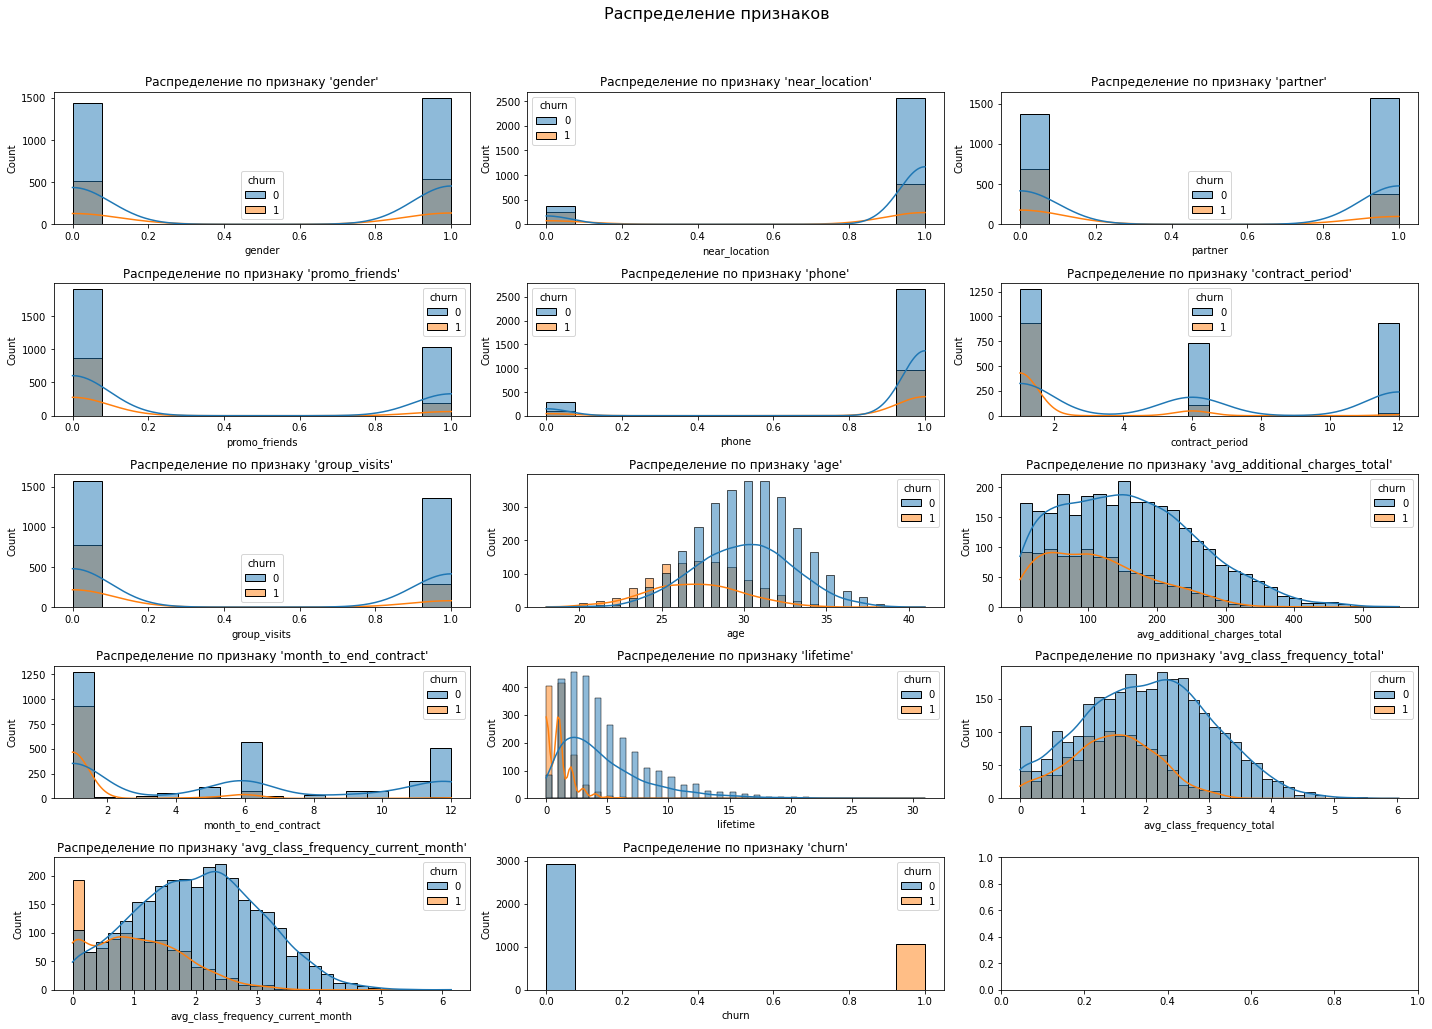

In [11]:
n_cols = 3
n_rows = int(np.ceil(len(df.columns)/n_cols)) 
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

axs = np.ravel(axs) 

plt.suptitle('Распределение признаков', size=16)

for ax, col in zip(axs, df.columns):
    sns.histplot(
        data=df, 
        x=col, 
        hue="churn", 
        ax=ax,
        kde=True, 
    )
    ax.set_title(f"Распределение по признаку '{col}'")
  
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show();

Гистограммы подтверждают выводы, сделанные нами в предыдущем пункте. 

Дополнительно можно отметить, что на графике распределения по признаку `avg_class_frequency_current_month` заметна аномально высокая доля клиентов, ушедших в отток, среди тех, кто ни разу не посещал тренировки - в принципе это логично, импульсивное решение "начать тренироваться завтра / с понедельника / с 1 января" так и не превратилось в реальные действия, и клиент ушел.

По распределению признака `lifetime` видно, что значительная часть клиентов склонна "отваливаться" в первые месяцы своей жизни, чем дольше срок - тем меньше доля ушедших клиентов, а после 5-6 месяцев посещений она вообще стремится к нулю. Регулярные занятия формируют привычку, а у кого-то даже зависимость от эндорфинов. 

Построим матрицу корреляций признаков, чтобы проверить нет ли среди них сильно взаимосвязанных пар признаков

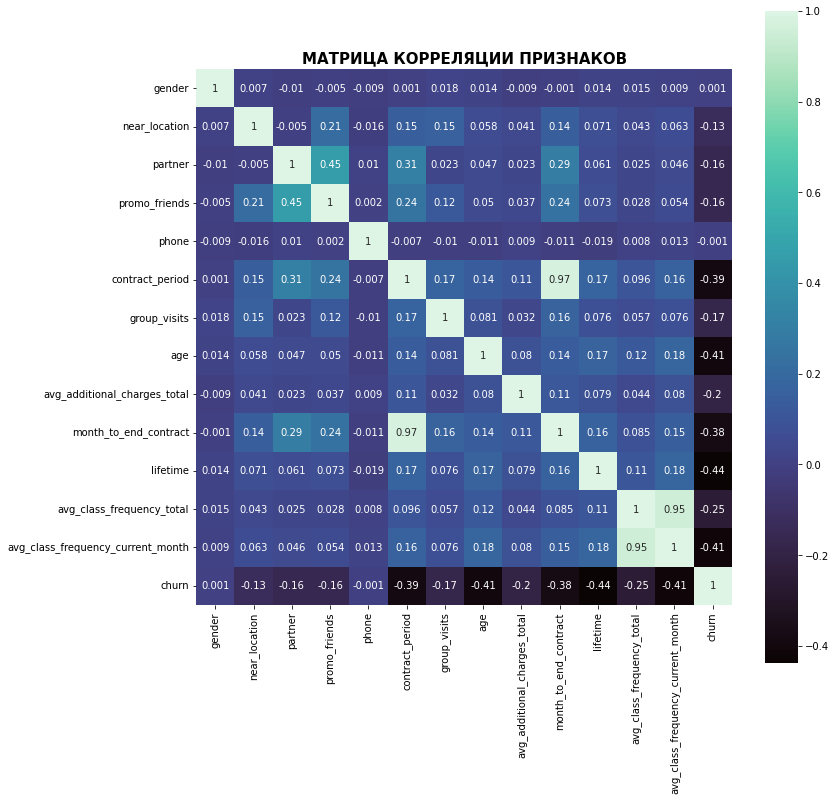

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr().round(3), annot=True, square=True, cmap='mako')
ax.set_title(label = 'МАТРИЦА КОРРЕЛЯЦИИ ПРИЗНАКОВ', fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.show();

Высокая корреляция наблюдается у пар признаков:  
- `contract_period` и `month_to_end_contract`,  
- `avg_class_frequency_total` и `avg_class_frequency_current_month`.

Об этом мы упоминали выше, когда исследовали данные описательной статистики по признакам. Матрица корреляции подтвердила наши предположения. Наличие мультиколлинеарности в данных может повлиять на результаты обучения линейных моделей, в результате чего мы получим нерепрезентативные веса у признаков и переобученный алгоритм. При выборе лучшей модели мы учтем фактор мультиколлинеарности и выберем оптимальный вариант на основе метрик.

Итак, мы завершили этап подготовки и исследовательского анализа данных.

Предварительные выводы:
- датасет содержит 2 пары признаков с высоким коэффициентом корреляции  
- выборки можно делить случайным образом, без учета времени, так как информация о времени или дате в датасете отсутствует  
- признаки "пол" и "наличие контактного телефона" скорее всего не влияют на отток  
- для склонности к оттоку скорее всего имеет значение близость фитнес-центра к месту проживания клиента, участие в промо-акции или партнерской программе, посещение групповых занятий
- особую важность для прогнозирования оттока могут иметь срок абонемента, время с момента первого посещения центра, частота посещений и сумма денег, которые клиент тратит на дополнительные услуги.

Приступим к выбору и обучению моделей.

## Прогнозирование оттока клиентов

Решить стоящую перед нами задачу прогнозирования оттока клиентов помогут алгоритмы бинарной классификации. Сначала разделим выборки на обучающую и валидационную в пропорции 80:20. Поскольку метки целевой перменной не сбалансированы, применим параметр "stratify=y", чтобы сохранить пропорциональность в подвыборках.

In [13]:
X = df.drop('churn', axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [14]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

MinMaxScaler()

В качестве моделей используем логистическую регрессию и случайный лес. Для оценки качества моделей мы будем использовать метрики `accuracy`, `precision` и `recall`, а также `roc_auc`, которая выражает степень уверенности модели в окончательном бинарном ответе. 

Используем модуль GridSearchCV, чтобы определить оптимальные параметры 'n_estimators' и 'max_depth' для случайного леса. В рамках данного исследования другие параметры не настраивались с помощью GridSearchCV, так как процесс занимает слишком долгое время. Для логистической регрессии параметр `C` попробуем ниже определить вручную в цикле.

In [15]:
clf = RandomForestClassifier()

params = { 
    'n_estimators': range (50, 101, 10),
    'max_depth': range (1, 13, 2),
}

grid = GridSearchCV(clf, params, cv=5)
grid.fit(X_train, y_train)
best_params = grid.best_params_
best_params

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 13, 2),
                         'n_estimators': range(50, 101, 10)})

{'max_depth': 11, 'n_estimators': 50}

Оптимальные параметры для случайного леса найдены. Используем их при обучении модели. Обучим оба алгоритма на обучающей выборке, построим прогнозы на валидационной и расчитаем метрики

In [16]:
models = [
    LogisticRegression(solver='liblinear', penalty='l1', random_state=0), 
    RandomForestClassifier(
        n_estimators=best_params['n_estimators'], 
        max_depth=best_params['max_depth'], 
        random_state=0
    ),
]

def make_predictions(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]
    print(
        'accuracy:{:.2f}, precision:{:.2f}, recall:{:.2f}, roc_auc:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            roc_auc_score(y_test, probs),
    )
         )

In [17]:
for model in models:
    print(model)
    make_predictions(model, df.drop('churn', axis=1), df['churn'])
    print()
    print()

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')
accuracy:0.92, precision:0.85, recall:0.83, roc_auc:0.97


RandomForestClassifier(max_depth=11, n_estimators=50, random_state=0)
accuracy:0.91, precision:0.83, recall:0.79, roc_auc:0.97




In [18]:
df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Метрика `accuracy` (доля правильных ответов) хорошо работает при условии сбалансированности классов. В нашем датасете клиентов, ушедших в отток, в три раза меньше, чем оставшихся. 

Для несбалансированных классов хорошо подходит метрика `roc_auc` (площадь под кривой). Она отражает "уверенность" модели в окончательном бинарном ответе. В нашем случае `roc_auc` для обеих моделей одинаковый и составляет 97%.

Метрики `precision` (точность) и `recall` (полнота) лучше у модели логистической регрессии.
Точность показывает насколько верно модель предсказала целевой класс, полнота - какую долю ушедших клиентов алгоритм смог идентифицировать. Для наших задач важно, чтобы модель не пропустила тех клиентов, которые уйдут в отток, то есть нам важно минимизировать долю прогнозов False Negative. Метрика `recall` считается по формуле $\frac{TP}{(TP + FN)}$, тогда как у `precision` в знаменателе сумма True Positive прогнозов и True Negative. Соответственно в нашем случае для оценки эффективности модели лучше подходит именно метрика полноты.

Показатель `recall` выше у логистической регрессии.

Поскольку в нашем датасете присутствуют сильно скоррелированные признаки, попробуем улучшить качество модели, удалив часть признаков вручную.

In [19]:
for model in models:
    print(model)
    make_predictions(
        model, 
        df.drop(['churn', 'avg_class_frequency_total', 'month_to_end_contract'], axis=1), 
        df['churn']
    )
    print()
    print()

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')
accuracy:0.90, precision:0.80, recall:0.82, roc_auc:0.96


RandomForestClassifier(max_depth=11, n_estimators=50, random_state=0)
accuracy:0.90, precision:0.80, recall:0.76, roc_auc:0.95




Метрики у модели логистической регрессии на датасете с удаленными признаками 'avg_class_frequency_total', 'month_to_end_contract' снова лучше, чем у случайного леса, однако хуже, чем в случае с полным набором признаков. Значит, удаление сильно скоррелированных признаков не приводит к улучшению качества модели.

Снова обучим модель логистической регрессии на полном датасете и попробуем найти оптимальное значение для параметра `C`. Он принимает значения от 0 до 1 и обозначает степень регуляризации модели. Чем он ниже, тем строже регуляризация

In [20]:
def optimizing_logreg_model(C):
    lrm = LogisticRegression(solver='liblinear', C=C, penalty='l1', random_state=0)
    lrm.fit(X_train, y_train)
    y_pred = lrm.predict(X_test)
    probs = lrm.predict_proba(X_test)[:,1]
    
    print(
        'accuracy:{:.2f}, precision:{:.2f}, recall:{:.2f}, roc_auc:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            roc_auc_score(y_test, probs),
        )
    )

for C in np.arange(0.1, 1.1, 0.1):
    print('C:{:.1f}'.format(C))
    optimizing_logreg_model(C)
    print()

C:0.1
accuracy:0.91, precision:0.87, recall:0.77, roc_auc:0.96

C:0.2
accuracy:0.92, precision:0.88, recall:0.80, roc_auc:0.97

C:0.3
accuracy:0.92, precision:0.88, recall:0.83, roc_auc:0.98

C:0.4
accuracy:0.93, precision:0.89, recall:0.83, roc_auc:0.98

C:0.5
accuracy:0.93, precision:0.89, recall:0.83, roc_auc:0.98

C:0.6
accuracy:0.93, precision:0.89, recall:0.83, roc_auc:0.98

C:0.7
accuracy:0.93, precision:0.88, recall:0.83, roc_auc:0.98

C:0.8
accuracy:0.93, precision:0.89, recall:0.83, roc_auc:0.98

C:0.9
accuracy:0.93, precision:0.89, recall:0.83, roc_auc:0.98

C:1.0
accuracy:0.93, precision:0.89, recall:0.83, roc_auc:0.98



Метрика roc_auc при всех значениях `С` одинаковая, остальные три метрики изменяются на одну сотую доли. Ранее мы приняли решение ориентироваться на метрику `recall`. Она максимальна для всех `С` начиная с С=0.3, в том числе и для С=1, который был установлен в алгоритме в качестве дефолтного значения. К сожалению, настройка параметра `С` не дала нам улучшения качества модели относительно изначального варианта. 



Посмотрим на веса перед признаками. Отсортируем их в порядке убывания абсолютного значения - так мы узнаем какие признаки алгоритм определил как самые важные для построения прогноза. 

In [21]:
lrm = LogisticRegression(solver='liblinear', penalty='l1', random_state=0)
lrm.fit(X_train, y_train)
y_pred = lrm.predict(X_test)

features = pd.DataFrame({'feature': X.columns, 'coef' : lrm.coef_.ravel().round(3)})
features['coef_abs'] = features['coef'].abs()
features.sort_values(by='coef_abs', ascending=False)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

,feature,coef,coef_abs
10,lifetime,-27.008,27.008
12,avg_class_frequency_current_month,-22.034,22.034
11,avg_class_frequency_total,16.988,16.988
7,age,-6.797,6.797
8,avg_additional_charges_total,-2.881,2.881
5,contract_period,-1.948,1.948
9,month_to_end_contract,-1.243,1.243
6,group_visits,-0.751,0.751
3,promo_friends,-0.295,0.295
2,partner,-0.101,0.101


Алгоритм логистической регрессии в качестве основных признаков, влияющих на прогноз целевой переменной, выделил следующие:  
- средняя частота посещений в неделю за предыдущий месяц,  
- средняя частота посещений в неделю за весь период,  
- время с момента первого обращения в фитнес-центр

У признаков "пол" и "локация" крайне малый абсолютный вес, и что удивительно, минимальный вес также у признака "дополнительные траты на услуги фитнес-центра", хотя изначально мы полагали, что этот признак оказывает влияние на склонность клиентов к оттоку.

Выводы по этапу 2:
- из двух моделей (логистическая регрессия и случайный лес) лучше себя показала логистическая регрессия  
- в качестве метрик оценки моделей использовались accuracy, precision, recall и roc_auc, причем для наших задач наиболее полно качество модели отражает метрика recall. В процессе тестирования моделей и определения оптимальных гиперпараметров максимальное значение метрики, которое удалось достичь, составило 0.83  
- логистическая регрессия показала, что максимальный вес имеют признаки, связанные с частотой посещения тренировок и временем с момента первого посещения; минимальный вес у признаков "пол", "локация" и "дополнительные траты клиента".

Переходим к следующему этапу - кластеризация клиентов

## Кластеризация клиентов

Для сегментации клиентов мы будем использовать алгоритм KMeans, основанный на расчете расстояний между точками. Данный алгоритм требует обязательной стандартизации данных и определения числа кластеров. Стандартизируем данные с помощью функции StandardScaler и построим дендрограмму, которая поможет нам определить оптимальное число групп для сегментации клиентов

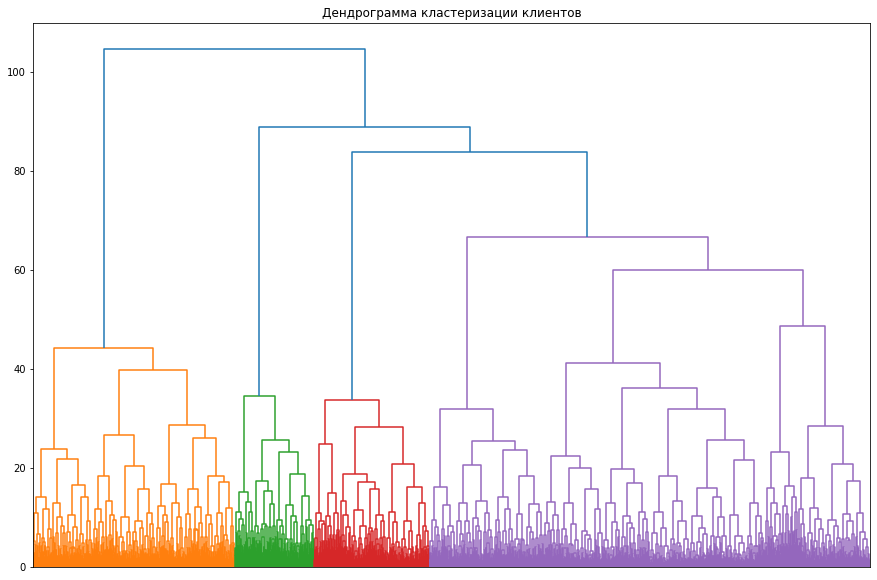

In [22]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')

plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Дендрограмма кластеризации клиентов')
plt.show();

На основании нарисованной на графике дендрограммы предлагаем разделить пользователей на 5 кластеров. 

На более ранних этапах исследования мы установили, что наш датасет содержит некоторые признаки с высокой степенью взаимной корреляции. Для нахождения более эффективной модели напишем функцию, которая на вход принимает матрицу признаков X и возвращает метрику `silhouette_score`. Протестируем модель со всеми признаками, и с признаками за исключением `month_to_end_contract` и `avg_class_frequency_total`, которые показали высокую корреляцию с `contract_period` и `avg_class_frequency_current_month` соответственно. По метрике определим какой вариант лучше.

In [23]:
def optimizing_kmeans(X):
    scaler = StandardScaler()
    X_st = scaler.fit_transform(X)
    km = KMeans(n_clusters=5, random_state=0)
    labels = km.fit_predict(X_st)
    return silhouette_score(X_st, labels)

optimizing_kmeans(df.drop('churn', axis=1))
optimizing_kmeans(df.drop(['churn', 'month_to_end_contract', 'avg_class_frequency_total'], axis=1))

0.14140955

0.13904734

Метрика силуэта принимает значение от -1 до 1, и чем ближе к 1, тем лучше. В нашем случае использование всех признаков в модели (без удаления части признаков вручную) показало лучшие результаты. Обучим первую модель заново и объединим метки кластеров с датасетом, чтобы изучить группы более подробно.

In [24]:
X = df.drop('churn', axis=1)
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_st)

In [25]:
lb = pd.DataFrame(labels)
df = df.join(lb, how='left').rename(columns={0:'label'})
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,label
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202934,12.0,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448486,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669865,12.0,2,3.205633,3.357214,0,0
4,1,1,1,1,1,1,0,26,198.362259,1.0,3,1.113884,1.120078,0,3


Сгруппируем датафрейм по меткам кластеров и расчитаем средние значения признаков

In [26]:
df.groupby('label').mean().round(2).T.style.background_gradient(axis=1)

label,0,1,2,3,4
gender,0.500000,0.520000,0.500000,0.490000,0.560000
near_location,0.960000,0.860000,0.000000,1.000000,0.980000
partner,0.780000,0.470000,0.460000,0.350000,0.360000
promo_friends,0.570000,0.310000,0.080000,0.240000,0.230000
phone,1.000000,0.000000,1.000000,1.000000,1.000000
contract_period,10.890000,4.790000,2.350000,1.950000,2.670000
group_visits,0.540000,0.430000,0.220000,0.340000,0.470000
age,29.980000,29.300000,28.480000,28.170000,30.130000
avg_additional_charges_total,160.759995,143.960007,135.460007,131.619995,161.660004
month_to_end_contract,9.950000,4.480000,2.200000,1.860000,2.460000


In [27]:
df['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

Итак, мы разделили клиентов на 5 кластеров и вывели средние значения по каждому признаку. Для некоторых признаков, таких как пол и возраст, средние в группах очень близки. У других видны существенные различия.

В частности,  
- расположение фитнес-клуба далеко от места проживания клиента характерно только для клиентов одной группы  
- клиенты без контактного телефона также попали в отдельную группу  
- признаки, связанные с длительностью абонемента (`contract_period` и `month_to_end_contract`) примерно равномерно распределились между группами (в одну из групп попали годовые контракты, в другую - полугодовые, а в трех оставшихся большую часть, судя по невысокому среднему значению, составляют абонементы на 1 месяц, преобладающие в выборке)  

Интересно, что в группу с самой низкой долей оттока попали клиенты со следующими признаками:  
- проживание рядом с клубом  
- большая доля клиентов по партнерской программе  
- более половины клиентов по промо-акции  
- годовой абонемент  
- более половины клиентов посещают групповые занятия
- в группе одни из самых высоких суммы трат нам дополнительные услуги центра
- средняя частота посещения одна из самых высоких среди 5 групп

Для группы с меткой 4, где доля клиентов, ушедших в отток также достаточно низкая (менее 10%), средние значения признаков "затраты на дополнительные услуги", "срок с момента первого посещения клуба", "средняя частота посещения клуба в неделю (как в общем, так и в последний месяц) очень высоки, по сравнению с остальными группами, однако средний срок абонемента здесь 2.5 месяца. Средние по признаку "партнерская программа" и "промо-акция" в этой группе низкие. Значит, мы можем сделать вывод, что данные признаки имеют второстепенное значение, как и длительность абонемента. Основной вес несут размер затрат на дополнительные услуги клуба и частота посещений.

Для клиентов с самой высокой долей оттока (кластеры с меткой 2 и 3) наблюдается обратная тенденция: самые низкие средние значения допольнительных трат и минимальная частота посещений. В кластер с меткой 2 также попали клиенты, проживающие далеко от фитнес-клуба и редко посещающие групповые занятия, скорее всего, долгая дорога и занятия в-одиночку не способствовали повышению мотивации к тренировкам.

Построим гистограммы распределения признаков

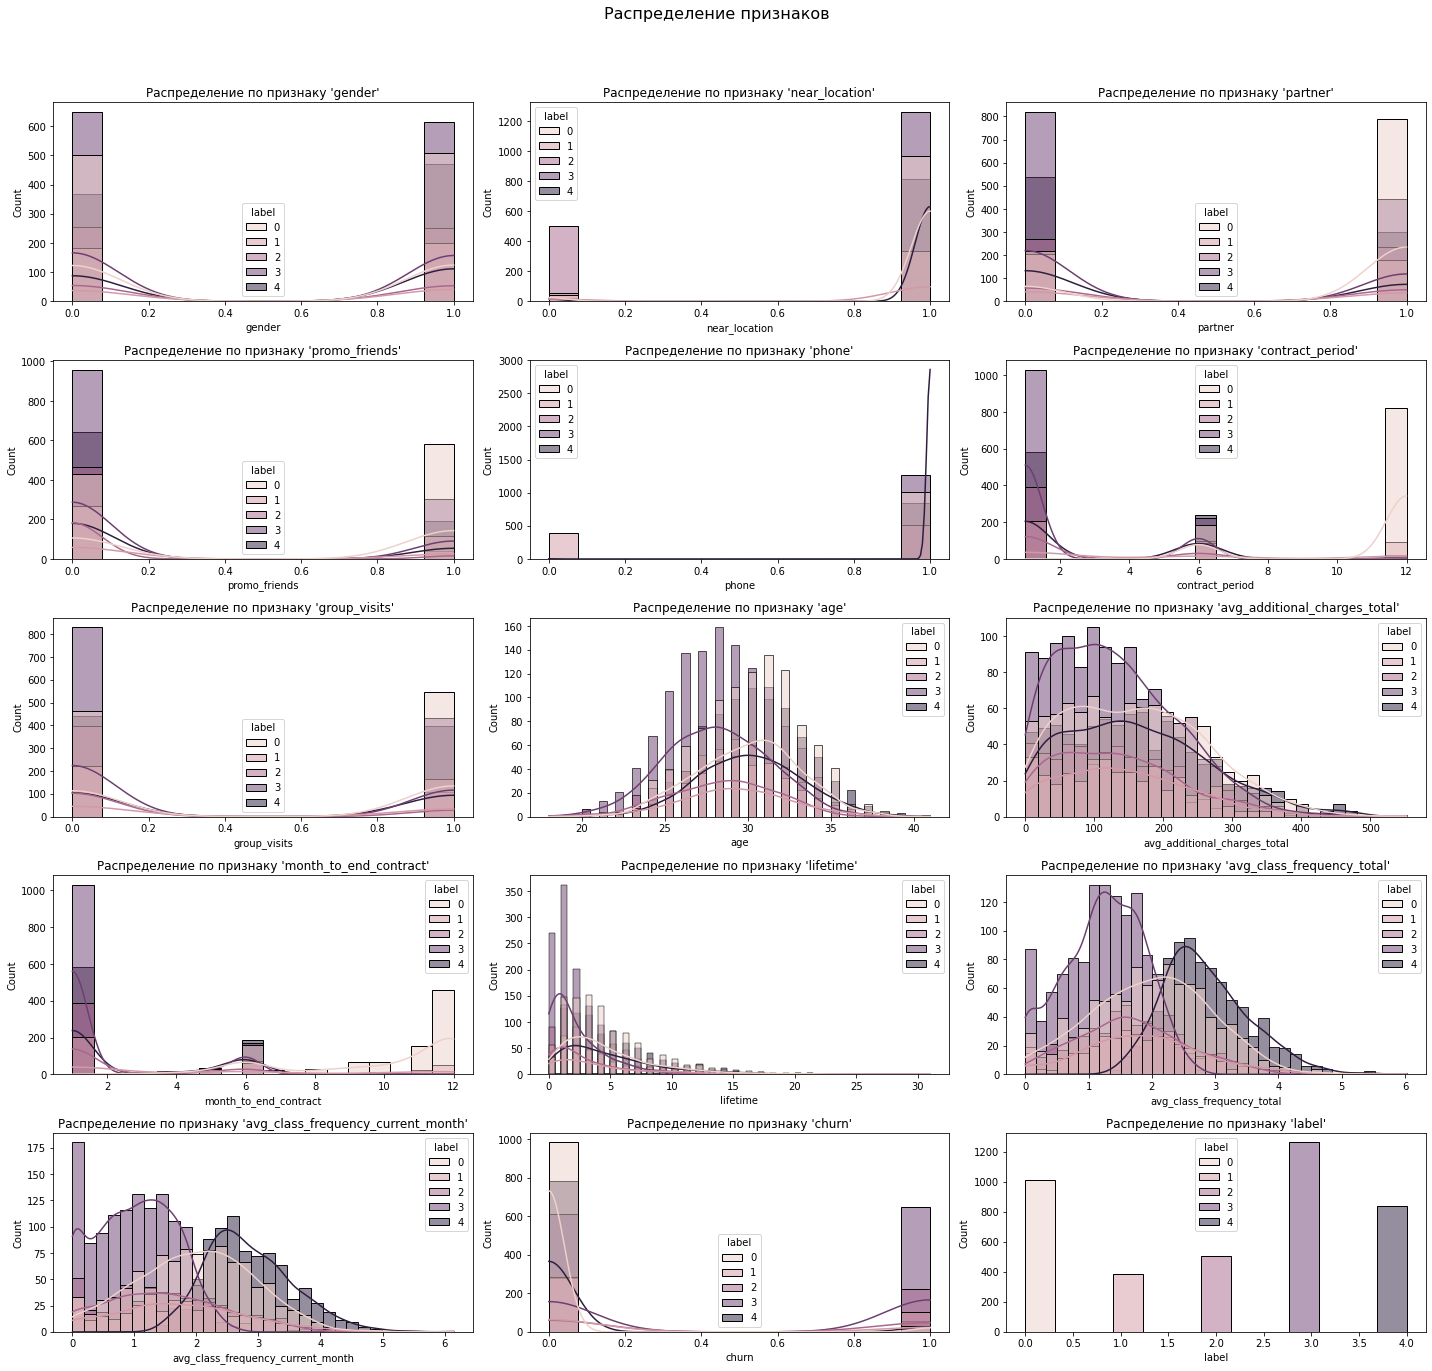

In [28]:
n_cols = 3
n_rows = int(np.ceil(len(df.columns)/n_cols)) 
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

axs = np.ravel(axs) 

plt.suptitle('Распределение признаков', size=16)

for ax, col in zip(axs, df.columns):
    sns.histplot(
        data=df, 
        x=col, 
        hue="label", 
        ax=ax,
        kde=True,
#         multiple='dodge'
    )
    ax.set_title(f"Распределение по признаку '{col}'")
  
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show();

Гистограммы подтверждают наши выводы, сделанные на основе анализа средних значений. В кластеры с метками 0 и 4 попали в-основном клиенты, не склонные к оттоку, тогда как клиенты из группы 2 и 3 могут с большей вероятностью покинуть фитнес-клуб в следующем месяце.

## Выводы и рекомендации

Мы исследовали датасет с информацией о клиентах фитнес-клуба. Часть из них перестали посещать занятия в прошлом месяце. Перед нами стояла задача сегментировать клиентов и выделить группы, наиболее склонные к оттоку, а также спрогнозировать вероятность ухода клиента в следующем месяце.

По имеющимся данным портрет клиента, попавшего в отток, следующий:
- пол может быть любым, как мужским так и женским
- клиент оформил абонемент на 1 месяц и ни разу не посетил ни одной тренировки 
- решение бросить занятия приходит как правило в первые 1-5 месяцев, после этого вероятность оттока снижается до минимума
- редко посещает групповые тренировки

Для прогнозирования оттока мы использовали модели бинарной классификации: логистическую регрессию и случайный лес. Обучающая и валидационная выборки делились случайным образом без учета времени в пропорции 80:20. Для оценки качества моделей были рассчитаны метрики accuracy, precision, recall и roc_auc. Для задач данного исследования метрика recall подходит больше остальных, так как нам важно, чтобы модель не пропустила клиента, который может уйти в отток, что повлечет за собой снижение дохода компании. По данному показателю логистическая регрессия продемонстрировала лучшие результаты, поэтому было принято решение использовать этот алгоритм.

Логистическая регрессия показала, что максимальный вес имеют признаки, связанные с частотой посещения тренировок и временем с момента первого посещения; минимальный вес у признаков "пол", "локация" и "дополнительные траты клиента".

Для сегментации клиентов мы использовали алгоритм KMeans, разделив клиентов на 5 групп. Данные были предварительно стандартизированы, так как модель чувствительна к масштабу признаков.

В частности,  
- расположение фитнес-клуба далеко от места проживания клиента характерно только для клиентов одной группы  
- клиенты без контактного телефона также попали в отдельную группу  
- признаки, связанные с длительностью абонемента (`contract_period` и `month_to_end_contract`) примерно равномерно распределились между группами (в одну из групп попали годовые контракты, в другую - полугодовые, а в трех оставшихся большую часть, судя по невысокому среднему значению, составляют абонементы на 1 месяц, преобладающие в выборке)  

Для групп с минимальной долей оттока характерны следующие признаки:  
- проживание клиента рядом с клубом  
- большая доля клиентов, пришедших по партнерской программе  
- более половины клиентов по промо-акции  
- годовой абонемент  
- более половины клиентов посещают групповые занятия
- клиенты много тратят на дополнительные услуги фитнес-центра
- посещают клуб чаще остальных

Для клиентов с самой высокой долей оттока (кластеры с меткой 2 и 3) наблюдается обратная тенденция: самые низкие средние значения допольнительных трат и минимальная частота посещений. В кластер с меткой 2 также попали клиенты, проживающие далеко от фитнес-клуба и не посещавщие групповые занятия - очевидно, долгая дорога и занятия в-одиночку не способствуют повышению мотивации к тренировкам.

Рекомендации по улучшению стратегии удержания клиентов:
- усилить вовлеченность действующих клиентов за счет приглашения к участию в групповых тренировках,  
- активизировать кросс-продажи сопутствующих услуг (фитнес-бар, спортивная экипировка и питание, услуги массажа, персональные тренировки и консультации и т.д.),  
- графики групповых тренировок строить таким образом, чтобы увеличить частоту посещения клиентами фитнес-клуба без ощущения перетренированности и демотивации,  
- для клиентов, предпочитающих самостоятельные занятия, разработать систему мониторинга посещаемости, в случае падения интереса - систему напоминаний, мотивационных пуш-уведомлений, статей о ЗОЖ и т.д.  

Для новых клиентов: 
- мотивировать клиентов приобретать долгосрочный абонемент за счет системы скидок, рассрочек, льготного кредитования,  
- таргетировать рекламную компанию на жителей близлежащих районов,   
- активно использовать партнерские организации для привлечения их сотрудников к занятиям в центре,  
- мониторить посещаемость новичков до момента формирования истинной вовлеченности (5-6 мес регулярных занятий).